<h1>Building a TF record<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Building-a-TF-Record" data-toc-modified-id="Building-a-TF-Record-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Building a TF Record</a></span><ul class="toc-item"><li><span><a href="#Importing-json-data-to-dataframe" data-toc-modified-id="Importing-json-data-to-dataframe-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importing json data to dataframe</a></span></li><li><span><a href="#Importing-tensorflow" data-toc-modified-id="Importing-tensorflow-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Importing tensorflow</a></span></li><li><span><a href="#Image-path-to-Image-tensor" data-toc-modified-id="Image-path-to-Image-tensor-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Image path to Image tensor</a></span></li><li><span><a href="#Stearing-normalization-and-Dataset-creation" data-toc-modified-id="Stearing-normalization-and-Dataset-creation-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Stearing normalization and Dataset creation</a></span></li><li><span><a href="#Looking-the-data" data-toc-modified-id="Looking-the-data-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Looking the data</a></span></li><li><span><a href="#Writing-dataset-to-tf-record" data-toc-modified-id="Writing-dataset-to-tf-record-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Writing dataset to tf record</a></span></li></ul></li></ul></div>

# Building a TF Record

## Importing json data to dataframe

In [1]:
import pandas as pd

In [2]:
def load_json_data(rc_data_path, eye_data_path, image_folder):
    rc_json = pd.read_json(rc_data_path, lines=True)
    zero_rc = rc_json['throttle'].min()
    rc_json = rc_json[rc_json['throttle'] > zero_rc]
    start_date = rc_json['timestamp'].min()
    
    images_json = pd.read_json(eye_data_path, lines=True)
    images_json = images_json[images_json['timestamp'] > start_date]
    
    rc_json['rc_timestamp'] = rc_json['timestamp']
    images_json['image_timestamp'] = images_json['timestamp']
    images_json['filename'] = image_folder + images_json['filename']
    
    df = pd.merge_asof(images_json, rc_json, on='timestamp', direction='nearest', suffixes=('image', 'rc'))
    
    df['time_derivation'] = (df['rc_timestamp'] - df['image_timestamp']).dt.total_seconds()
    
    df = df.drop(['rc_timestamp','image_timestamp', 'source'], axis=1)
    return df

In [3]:
df = load_json_data('../data/rc/json_data.json', '../data/images/json_data.json', '../data/images/')

In [4]:
df.count()

filename           47266
height             47266
timestamp          47266
width              47266
stearing           47266
throttle           47266
time_derivation    47266
dtype: int64

## Importing tensorflow

In [5]:
import tensorflow as tf
tf.enable_eager_execution()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Image path to Image tensor

In [6]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, dtype=tf.float32)
    image /= 255.0  # normalize to [0,1] range
    return image

In [7]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

../data/images/2019_10_12_07_17_38_085329.jpg
(180, 320, 3)
()


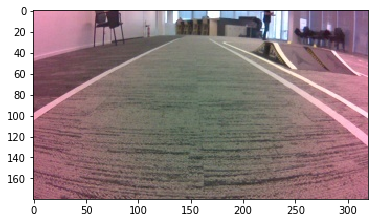

In [9]:
import matplotlib.pyplot as plt

image_path = df['filename'].values[0]
print(image_path)
image = load_and_preprocess_image(image_path)
print(image.shape)
plt.imshow(image)
plt.grid(False)
print()

## Stearing normalization and Dataset creation

In [10]:
def describe_tensor(tensor):
    t = tensor.numpy()
    print('mean : %f' % t.mean())
    print('std : %f' % t.std())
    print('max : %f' % t.max())
    print('min : %f' % t.min())

In [11]:
def normalize_tensor(tensor):
    return (tensor -  tf.reduce_min(tensor)) /  (tf.reduce_max(tensor) - tf.reduce_min(tensor))

In [12]:
def get_tensors(df):
    stearing_tensor = tf.convert_to_tensor(df['stearing'].values, dtype=tf.float32)
    normalize_stearing_tensor = normalize_tensor(stearing_tensor)
    
    throttle_tensor = tf.convert_to_tensor(df['throttle'].values, dtype=tf.float32)
    normalize_throttle_tensor = normalize_tensor(throttle_tensor)
    
    image_path_tensor = tf.convert_to_tensor(df['filename'].values, dtype=tf.string)
    
    return normalize_stearing_tensor, normalize_throttle_tensor, image_path_tensor

In [13]:
normalize_stearing_tensor, normalize_throttle_tensor, image_path_tensor = get_tensors(df)


In [14]:
describe_tensor(normalize_stearing_tensor)

mean : 0.453321
std : 0.191669
max : 1.000000
min : 0.000000


In [15]:
describe_tensor(normalize_throttle_tensor)

mean : 0.346618
std : 0.188886
max : 1.000000
min : 0.000000


In [16]:
features_dataset = tf.data.Dataset.from_tensor_slices({
    'stearing': normalize_stearing_tensor,
    'throttle': normalize_throttle_tensor,
    'image': image_path_tensor})
features_dataset

<DatasetV1Adapter shapes: {stearing: (), image: (), throttle: ()}, types: {stearing: tf.float32, image: tf.string, throttle: tf.float32}>

## Looking the data

In [35]:
import numpy as np
from IPython.display import HTML
from PIL import ImageDraw
from PIL import Image
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from ipywidgets import FloatProgress
from IPython.display import display

def make_video(images_paths, stearing):

    start = 1
    end = len(stearing)
    sample = Image.open(images_paths[0])
    x, y = sample.size
    sample.close()
    print("Building Video")
    fp = FloatProgress(min=0, max=end)
    display(fp)
    figure = plt.figure()
    imageplot = plt.imshow(np.zeros((y, x, 3), dtype=np.uint8))
    val_idx = start
    def next_frame(i):
        im = Image.open(images_paths[i])
        draw = ImageDraw.Draw(im)
        p = x - (x * stearing[i]) - 1
        draw.line((205,308, p, 0),fill=(0,255,0,128))
        imageplot.set_array(im)
        im.close()
        fp.value += 1
        return imageplot,

    animate = animation.FuncAnimation(figure, next_frame, frames=range(start, end), interval=200, blit=False)
    print("Saving mp4")
    #animate.save("video.mp4")
    fp.value=0
    print("Building HTML animation")
    return animate

Building Video


FloatProgress(value=0.0, max=12316.0)

Saving mp4
Building HTML animation


W1011 02:13:09.609709 140736241718080 animation.py:1364] Animation movie is 106012510 bytes, exceeding the limit of 20971520.0. If you're sure you want a large animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB).


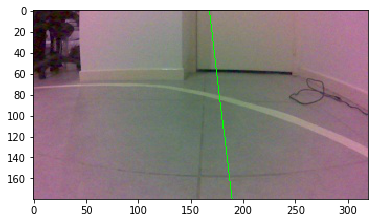

In [36]:
animate = make_video(df['filename'].values, normalize_stearing_tensor.numpy())
HTML(animate.to_html5_video())

## Writing dataset to tf record

In [17]:
def load_images(row):
    row['image'] = tf.io.read_file(row['image'])
    return row

In [18]:
from datetime import datetime
now = datetime.now().strftime("%Y%m%d_%H%M%S")
features_ds = features_dataset.map(load_images, num_parallel_calls=AUTOTUNE)

In [19]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [20]:
def serialize_example(stearing, throttle, image):
    """
    Creates a tf.Example message ready to be written to a file.
    """

    # Create a dictionary mapping the feature name to the tf.Example-compatible
    # data type.
    feature = {
      'stearing': _float_feature(stearing.numpy()),
      'throttle': _float_feature(throttle.numpy()),
      'image': _bytes_feature(image.numpy())
    }

    # Create a Features message using tf.train.Example.

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [21]:
def tf_serialize_example(row):
    tf_string = tf.py_function(
        serialize_example,
        (row['stearing'],row['throttle'],row['image']),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

In [22]:
df.count()

filename           47266
height             47266
timestamp          47266
width              47266
stearing           47266
throttle           47266
time_derivation    47266
dtype: int64

In [23]:
serialized_features_dataset = features_ds.map(tf_serialize_example)
features_tfrec = tf.data.experimental.TFRecordWriter('../data/arion_dataset_%s.tfrec' % now)
features_tfrec.write(serialized_features_dataset)

W1012 10:02:11.128413 123145514229760 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W1012 10:02:11.131011 123145514229760 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W1012 10:02:11.133739 123145514229760 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W1012 10:02:11.136296 123145516912640 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W1012 10:02:11.139642 123145514229760 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
